In [13]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from pathlib import Path
from fastai.tabular.all import *

import plotly.io as pio

pio.renderers.default = 'colab'

# Import data

In [16]:
data_path = Path('data/rnn')

train = pd.read_csv(data_path / 'Google_Stock_Price_Train.csv')
train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [17]:
train_np = train.Open.values.reshape(-1, 1)
train_np.shape, train_np

((1258, 1),
 array([[325.25],
        [331.27],
        [329.83],
        ...,
        [793.7 ],
        [783.33],
        [782.75]]))

# Feature scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))

In [5]:
train_np_scaled = sc.fit_transform(train_np)
train_np_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [6]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
train['open_scaled'] = sc.fit_transform(train.Open.values.reshape(-1, 1))
# (train.Open - train.Open.min()) / (train.Open.max() - train.Open.min())
train

,Date,Open,High,Low,Close,Volume,open_scaled
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500",0.085814
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400",0.097012
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300",0.094334
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900",0.091562
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800",0.079842
...,...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400",0.952043
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100",0.951633
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800",0.957251
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300",0.937960


# Add lag features

In [18]:
for i in range(60):
    train[f'lag_{i+1}'] = train.Open.shift(i+1)
    
train_lag = train.dropna()
train_lag

,Date,Open,High,Low,Close,Volume,lag_1,lag_2,lag_3,lag_4,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
60,3/29/2012,325.50,327.07,320.95,646.63,"3,862,900",324.80,322.31,321.30,322.09,...,314.81,311.96,314.43,310.59,313.70,322.04,328.34,329.83,331.27,325.25
61,3/30/2012,324.66,325.52,319.30,639.48,"4,638,700",325.50,324.80,322.31,321.30,...,312.14,314.81,311.96,314.43,310.59,313.70,322.04,328.34,329.83,331.27
62,4/2/2012,319.19,322.54,316.23,645.15,"4,585,400",324.66,325.50,324.80,322.31,...,319.30,312.14,314.81,311.96,314.43,310.59,313.70,322.04,328.34,329.83
63,4/3/2012,321.50,322.77,318.13,640.86,"4,105,000",319.19,324.66,325.50,324.80,...,294.16,319.30,312.14,314.81,311.96,314.43,310.59,313.70,322.04,328.34
64,4/4/2012,318.03,318.31,314.37,633.41,"3,267,300",321.50,319.19,324.66,325.50,...,291.91,294.16,319.30,312.14,314.81,311.96,314.43,310.59,313.70,322.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400",792.36,795.84,796.76,790.22,...,783.76,786.66,777.71,779.66,779.00,779.31,776.03,774.25,776.33,781.44
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100",790.90,792.36,795.84,796.76,...,781.22,783.76,786.66,777.71,779.66,779.00,779.31,776.03,774.25,776.33
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800",790.68,790.90,792.36,795.84,...,781.65,781.22,783.76,786.66,777.71,779.66,779.00,779.31,776.03,774.25
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300",793.70,790.68,790.90,792.36,...,779.80,781.65,781.22,783.76,786.66,777.71,779.66,779.00,779.31,776.03


In [19]:
cont = [f'lag_{i+1}' for i in range(60)]
cat = []
dep = 'Open'
splits = RandomSplitter(seed=42)(train_lag)

tp = TabularPandas(
    train_lag,
    procs=[Categorify, FillMissing, Normalize], 
    cat_names=cat,
    cont_names=cont,
    y_names=dep,
    splits=splits
)

tp.show(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,Open
490,537.770020,541.669983,536.070007,533.500000,532.900024,526.630005,523.719971,523.510010,529.770020,529.099976,529.030029,522.340027,516.640015,514.780029,511.579987,513.049988,513.929993,515.940002,515.500000,515.030029,501.500000,501.970001,502.869995,502.489990,509.399994,510.890015,508.269989,513.820007,513.969971,512.539978,516.780029,507.649994,505.700012,512.489990,514.010010,498.630005,500.619995,503.839996,486.470001,444.829987,441.279999,436.239990,431.709991,431.399994,430.309998,426.540009,431.040009,432.109985,435.869995,442.339996,439.720001,438.480011,432.920013,435.779999,437.510010,441.619995,441.589996,446.399994,447.519989,451.299988,535.690002
995,753.000000,741.789978,741.159973,752.849976,759.169983,757.890015,767.770020,753.099976,766.010010,768.900024,747.109985,748.809998,748.460022,748.140015,752.000000,757.450012,746.530029,738.739990,727.580017,729.289978,715.599976,729.169983,731.000000,732.460022,724.400024,730.200012,731.500000,729.469971,722.000000,718.859985,711.059998,715.729980,710.500000,707.330017,707.380005,701.549988,727.500000,646.700012,654.150024,664.039978,661.179993,664.109985,654.659973,653.210022,643.150024,642.090027,640.000000,641.359985,649.239990,638.840027,632.000000,607.200012,608.369995,603.280029,597.280029,610.340027,629.770020,616.640015,622.049988,627.000000,750.000000
172,341.700012,338.730011,341.000000,340.720001,340.839966,337.420013,331.260010,330.260010,336.540009,335.880005,332.440002,335.299988,336.489990,335.799988,332.510010,333.890015,328.390015,322.500000,318.100006,321.049988,318.329987,319.700012,318.609985,318.809998,311.589996,317.459991,312.959991,316.839996,308.290009,306.350006,303.019989,306.350006,299.119995,303.239990,291.980011,287.410004,288.140015,287.109985,285.010010,282.500000,287.070007,293.989990,291.380005,295.119995,293.279999,288.920013,289.820007,286.410004,281.890015,282.790009,280.329987,282.609985,282.940002,288.839996,288.820007,285.720001,280.260010,279.119995,279.600006,279.809998,348.690002


In [20]:
dls = tp.dataloaders(32)
[t.shape for t in dls.one_batch()]

[torch.Size([32, 0]), torch.Size([32, 60]), torch.Size([32, 1])]

# RNN module

In [60]:
class RNN(nn.Module):
    def __init__(self, num_layers=4, hidden_size=50):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # self.hidden_state = torch.zeros(self.num_layers, 32, self.hidden_size).cuda()
        # self.cell_state = torch.zeros(self.num_layers, 32, self.hidden_size).cuda()
        
        self.lstm = nn.LSTM(
            input_size=60,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True,
        )
        self.bn = nn.BatchNorm1d(self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
        
    
    def forward(self, cat, cont):
        X = cont.reshape(-1, 1, 60)
        
        # hidden_state = hidden_state.to(device)
        # cell_state = cell_state.to(device)
        # print(X.device, hidden_state.device, cell_state.device)
        hidden_state = torch.zeros(self.num_layers, X.size(0), self.hidden_size).cuda()
        cell_state = torch.zeros(self.num_layers, X.size(0), self.hidden_size).cuda()
        out, (hidden, cell) = self.lstm(X, (hidden_state, cell_state))
        
        # out, (hidden, cell) = self.lstm(X, (self.hidden_state, self.cell_state))
        # self.hidden_state = hidden.detach()
        # self.cell_state = cell.detach()
        out = out[:, -1, :]
        # out = self.linear(out)
        out = self.linear(self.bn(out))
        return out

In [31]:
num_layers = 2
hidden_size = 50

model = RNN(num_layers=num_layers, hidden_size=hidden_size)

In [32]:
cat, cont, yb = dls.one_batch()
X = cont.reshape(-1, 1, 60)
X.size()

torch.Size([32, 1, 60])

In [28]:
# Hidden state:
hidden_state = torch.zeros(num_layers, X.size(0), hidden_size)
# Cell state:
cell_state = torch.zeros(num_layers, X.size(0), hidden_size)

In [33]:
model.forward(cat, cont).shape

torch.Size([32, 1])

In [29]:
X = cont.reshape(32, 1, 60)
out, (h, c) = model.lstm(X, (hidden_state, cell_state))
out.shape, h.shape, c.shape

(torch.Size([32, 1, 50]), torch.Size([2, 32, 50]), torch.Size([2, 32, 50]))

In [390]:
out.reshape(-1, 50).shape

torch.Size([32, 50])

In [61]:
model = RNN()
model

RNN(
  (lstm): LSTM(60, 50, num_layers=4, batch_first=True, dropout=0.2)
  (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [62]:
learn = Learner(dls, model, loss_func=F.mse_loss, metrics=F.l1_loss)

SuggestedLRs(slide=6.309573450380412e-07, valley=0.10000000149011612)

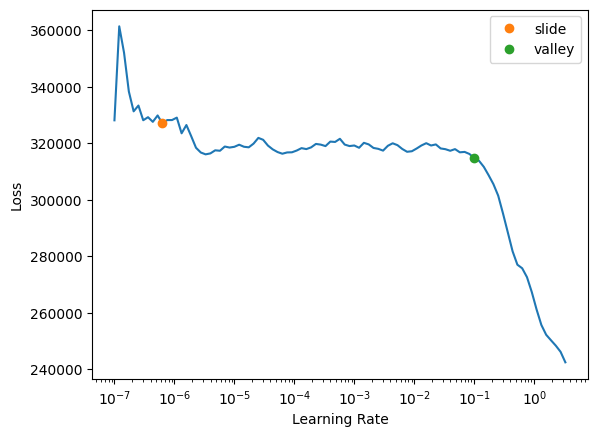

In [63]:
learn.lr_find(suggest_funcs=[slide, valley])

In [64]:
learn.fit_one_cycle(50, lr_max=0.05, wd=0.1)

epoch,train_loss,valid_loss,l1_loss,time
0,319035.187500,319174.093750,546.576477,00:00
1,316584.500000,313579.937500,544.485840,00:00
2,311594.093750,297647.812500,533.887024,00:00
3,297944.031250,255107.296875,500.955017,00:00
4,266026.281250,197273.625000,442.625916,00:00
5,207554.671875,96302.695312,308.488251,00:00
6,130650.367188,10649.076172,96.324875,00:00
7,73639.867188,945.432678,24.573013,00:00
8,41806.921875,2046.446533,34.122005,00:00
9,24336.478516,1383.396240,29.859072,00:00


# Predict

In [65]:
test = pd.concat([pd.read_csv(data_path / 'Google_Stock_Price_Train.csv'), pd.read_csv(data_path / 'Google_Stock_Price_Test.csv')])
test

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
15,1/25/2017,829.62,835.77,825.06,835.67,"1,494,500"
16,1/26/2017,837.81,838.00,827.01,832.15,"2,973,900"
17,1/27/2017,834.71,841.95,820.44,823.31,"2,965,800"
18,1/30/2017,814.66,815.84,799.80,802.32,"3,246,600"


In [66]:
for i in range(60):
    test[f'lag_{i+1}'] = test.Open.shift(i+1)
    
test_lag = test.dropna().copy()
test_lag

,Date,Open,High,Low,Close,Volume,lag_1,lag_2,lag_3,lag_4,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
60,3/29/2012,325.50,327.07,320.95,646.63,"3,862,900",324.80,322.31,321.30,322.09,...,314.81,311.96,314.43,310.59,313.70,322.04,328.34,329.83,331.27,325.25
61,3/30/2012,324.66,325.52,319.30,639.48,"4,638,700",325.50,324.80,322.31,321.30,...,312.14,314.81,311.96,314.43,310.59,313.70,322.04,328.34,329.83,331.27
62,4/2/2012,319.19,322.54,316.23,645.15,"4,585,400",324.66,325.50,324.80,322.31,...,319.30,312.14,314.81,311.96,314.43,310.59,313.70,322.04,328.34,329.83
63,4/3/2012,321.50,322.77,318.13,640.86,"4,105,000",319.19,324.66,325.50,324.80,...,294.16,319.30,312.14,314.81,311.96,314.43,310.59,313.70,322.04,328.34
64,4/4/2012,318.03,318.31,314.37,633.41,"3,267,300",321.50,319.19,324.66,325.50,...,291.91,294.16,319.30,312.14,314.81,311.96,314.43,310.59,313.70,322.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,1/25/2017,829.62,835.77,825.06,835.67,"1,494,500",822.30,807.25,806.91,805.12,...,779.94,783.40,774.50,750.66,767.25,778.20,782.89,795.47,808.35,801.00
16,1/26/2017,837.81,838.00,827.01,832.15,"2,973,900",829.62,822.30,807.25,806.91,...,791.17,779.94,783.40,774.50,750.66,767.25,778.20,782.89,795.47,808.35
17,1/27/2017,834.71,841.95,820.44,823.31,"2,965,800",837.81,829.62,822.30,807.25,...,756.54,791.17,779.94,783.40,774.50,750.66,767.25,778.20,782.89,795.47
18,1/30/2017,814.66,815.84,799.80,802.32,"3,246,600",834.71,837.81,829.62,822.30,...,755.60,756.54,791.17,779.94,783.40,774.50,750.66,767.25,778.20,782.89


In [67]:
test_dl = learn.dls.test_dl(test_lag)
preds, targs = learn.get_preds(dl=test_dl)

In [68]:
test_lag['pred'] = preds
test_lag

,Date,Open,High,Low,Close,Volume,lag_1,lag_2,lag_3,lag_4,...,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,pred
60,3/29/2012,325.50,327.07,320.95,646.63,"3,862,900",324.80,322.31,321.30,322.09,...,311.96,314.43,310.59,313.70,322.04,328.34,329.83,331.27,325.25,316.028992
61,3/30/2012,324.66,325.52,319.30,639.48,"4,638,700",325.50,324.80,322.31,321.30,...,314.81,311.96,314.43,310.59,313.70,322.04,328.34,329.83,331.27,317.014771
62,4/2/2012,319.19,322.54,316.23,645.15,"4,585,400",324.66,325.50,324.80,322.31,...,312.14,314.81,311.96,314.43,310.59,313.70,322.04,328.34,329.83,317.997528
63,4/3/2012,321.50,322.77,318.13,640.86,"4,105,000",319.19,324.66,325.50,324.80,...,319.30,312.14,314.81,311.96,314.43,310.59,313.70,322.04,328.34,318.067596
64,4/4/2012,318.03,318.31,314.37,633.41,"3,267,300",321.50,319.19,324.66,325.50,...,294.16,319.30,312.14,314.81,311.96,314.43,310.59,313.70,322.04,318.951294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,1/25/2017,829.62,835.77,825.06,835.67,"1,494,500",822.30,807.25,806.91,805.12,...,783.40,774.50,750.66,767.25,778.20,782.89,795.47,808.35,801.00,764.983032
16,1/26/2017,837.81,838.00,827.01,832.15,"2,973,900",829.62,822.30,807.25,806.91,...,779.94,783.40,774.50,750.66,767.25,778.20,782.89,795.47,808.35,765.526245
17,1/27/2017,834.71,841.95,820.44,823.31,"2,965,800",837.81,829.62,822.30,807.25,...,791.17,779.94,783.40,774.50,750.66,767.25,778.20,782.89,795.47,766.173340
18,1/30/2017,814.66,815.84,799.80,802.32,"3,246,600",834.71,837.81,829.62,822.30,...,756.54,791.17,779.94,783.40,774.50,750.66,767.25,778.20,782.89,766.437256


In [69]:
import plotly.express as px

px.line(test_lag, x='Date', y=['Open', 'pred'])